In [404]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.ops import unary_union

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Transformer
from ast import literal_eval
from shapely.ops import unary_union

# 1. 데이터 불러오기 및 전처리
- (`area_results`, `wifi_count_by_area`, `foot_traffic_data_loc`)

In [564]:
FOOT_TRAFFIC_DATA_PATH = './data/Foot-Trafic/api_data/Foot-Traffic-DataSet/'
PLACE116_COOR = './data/all_coord_df.csv'
WIFI_COOR = './data/Public-WiFi/PublicWiFi.csv'

## 1-1. 116개의 명소별 면적

In [565]:
import geopandas as gpd

In [566]:
# 116개의 명소 경계좌표
coor_116place = pd.read_csv(PLACE116_COOR, index_col=0)

In [567]:
# 좌표 변환기 (EPSG:4326 -> EPSG:5179)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:5179", always_xy=True)

In [568]:
# 면적 계산 함수 (M^2 단위)
def calculate_area_m2(row):
    polygon_coords = []

    # 다각형 좌표 추출 및 변환
    for col in coor_116place.columns[4:]:
        if not pd.isna(row[col]):  # NaN 값이 아닌 경우만 처리
            coord = literal_eval(row[col])
            polygon_coords.append((coord[0], coord[1]))  # (경도, 위도)

    # 좌표 변환 및 면적 계산
    if polygon_coords:
        # 좌표 변환 (EPSG:4326 -> EPSG:5179)
        transformed_coords = [
            transformer.transform(lon, lat) for lon, lat in polygon_coords
        ]

        # 다각형 생성 및 면적 계산
        polygon = Polygon(transformed_coords)
        return polygon.area / 1_000  # 면적을 M^2 단위로 변환
    return 0

In [569]:
# 면적 계산 (벡터화)
coor_116place["AREA_M2"] = coor_116place.apply(calculate_area_m2, axis=1)

# 결과 저장
area_gdf = coor_116place[["AREA_NM", "AREA_M2"]]

In [570]:
# 다각형 생성
polygons = []
names = []
for _, row in coor_116place.iterrows():
    polygon_coords = []
    for col in coor_116place.columns[3:]:  # 좌표 데이터가 3열부터 시작
        if not pd.isna(row[col]):  # NaN 값이 아닌 경우만 처리
            coord_value = row[col]
            if isinstance(coord_value, str) and coord_value.startswith("(") and coord_value.endswith(")"):
                try:
                    coord = literal_eval(coord_value)  # 문자열 -> (경도, 위도) 튜플 변환
                    polygon_coords.append((coord[0], coord[1]))  # (경도, 위도)
                except (ValueError, SyntaxError):
                    continue

    if polygon_coords:  # 다각형 좌표가 존재하면
        polygon = Polygon(polygon_coords)
        polygons.append(polygon)
        names.append(row['AREA_NM'])

In [571]:
# GeoDataFrame 생성
area_results = gpd.GeoDataFrame(
    {'AREA_NM': names, 'geometry': polygons},
    crs="EPSG:4326"
)

In [572]:
len(area_results['AREA_NM'].unique())

115

In [573]:
area_results

,AREA_NM,geometry
0,강남 MICE 관광특구,"POLYGON ((127.06028 37.5139, 127.0604 37.51385..."
1,동대문 관광특구,"POLYGON ((127.01759 37.5695, 127.01772 37.5693..."
2,명동 관광특구,"POLYGON ((126.97601 37.56067, 126.97602 37.560..."
3,이태원 관광특구,"POLYGON ((126.99125 37.5303, 126.99121 37.5302..."
4,잠실 관광특구,"POLYGON ((127.09307 37.51051, 127.09272 37.511..."
...,...,...
110,잠원한강공원,"POLYGON ((127.02121 37.53022, 127.02357 37.532..."
111,청계산,"POLYGON ((127.04946 37.45425, 127.06166 37.439..."
112,청와대,"POLYGON ((126.97924 37.58373, 126.97925 37.583..."
113,북창동 먹자골목,"POLYGON ((126.97601 37.56067, 126.97602 37.560..."


In [574]:
area_results['AREA_M2'] = area_gdf['AREA_M2']

## 1-2. 지역별 와이파이 개수

In [575]:
from shapely.geometry import Point, Polygon
from ast import literal_eval

In [576]:
wifi_data = pd.read_csv(WIFI_COOR, index_col=0)
wifi_data.head(3)

,시도,시군구,상세주소,ap명,위도,경도
번호,,,,,,
1,강원도,강릉시,옥계면 금진리 464-1번지,(재)한국여성수련원,37.629313,129.046503
2,강원도,강릉시,옥계면 금진리 464-1번지,(재)한국여성수련원,37.629313,129.046503
3,강원도,강릉시,옥계면 금진리 464-1번지,(재)한국여성수련원,37.629313,129.046503


In [577]:
wifi_data = wifi_data[wifi_data['시도']=='서울특별시']

In [578]:
# 2. 명소 영역을 40미터 확장 (buffer 사용, 단위는 CRS에 따라 결정됨)
# 와이파이 사용 가능 범위인 40m 적용하여 와이파이 개수 계산
buffered_area_results = area_results.copy()
buffered_area_results = buffered_area_results.to_crs(epsg=5179)

# 명소 영역을 40미터 확장
buffered_area_results['geometry'] = buffered_area_results.geometry.buffer(40)

# 다시 EPSG:4326으로 변환
buffered_area_results = buffered_area_results.to_crs(epsg=4326)

In [579]:
public_wifi_gdf = gpd.GeoDataFrame(
    wifi_data,
    geometry=gpd.points_from_xy(wifi_data['경도'], wifi_data['위도']),
    crs="EPSG:4326"
)

In [580]:
joined_gdf = gpd.sjoin(public_wifi_gdf, buffered_area_results, how='right', predicate='intersects')

In [581]:
wifi_count_by_area = joined_gdf.groupby('AREA_NM').size().reset_index(name='WiFi_Count')

## 1-3. 유동인구수

In [582]:
foottraffic_file_names = os.listdir(FOOT_TRAFFIC_DATA_PATH)

In [583]:
dataframes = []
for dataset_name in foottraffic_file_names :
    file_path = FOOT_TRAFFIC_DATA_PATH+dataset_name
    df = pd.read_csv(file_path, encoding='euc-kr')
    dataframes.append(df)

In [584]:
dataframes = []
for dataset_name in foottraffic_file_names :
    file_path = FOOT_TRAFFIC_DATA_PATH+dataset_name
    df = pd.read_csv(file_path, encoding='euc-kr')
    dataframes.append(df)

In [585]:
foot_traffic_data = pd.concat(dataframes, ignore_index=True)

In [586]:
foot_traffic_data.rename(columns={'핫스팟 장소명':'AREA_NM'}, inplace=True)

In [587]:
foot_traffic_data['실시간 인구현황'].isnull().count()

np.int64(172650)

In [588]:
foot_traffic_data.drop(columns=['실시간 인구현황'], inplace=True)

In [589]:
foot_traffic_data.columns = foot_traffic_data.columns.str.replace(' ', '')

In [590]:
foot_traffic_data['AREA_NM'].unique()

array(['4·19 카페거리', 'DDP(동대문디자인플라자)', 'DMC(디지털미디어시티)', '가락시장', '가로수길',
       '가산디지털단지역', '강남 MICE 관광특구', '강남역', '강서한강공원', '건대입구역', '경복궁', '고덕역',
       '고속터미널역', '고척돔', '광나루한강공원', '광장(전통)시장', '광화문·덕수궁', '광화문광장', '교대역',
       '구로디지털단지역', '구로역', '국립중앙박물관·용산가족공원', '군자역', '김포공항', '낙산공원·이화마을',
       '난지한강공원', '남구로역', '남대문시장', '남산공원', '노들섬', '노량진', '대림역', '덕수궁길·정동길',
       '동대문 관광특구', '동대문역', '뚝섬역', '뚝섬한강공원', '망원한강공원', '명동 관광특구', '미아사거리역',
       '반포한강공원', '발산역', '방배역 먹자골목', '보신각', '북서울꿈의숲', '북창동 먹자골목', '북촌한옥마을',
       '북한산우이역', '불광천', '사당역', '삼각지역', '서리풀공원·몽마르뜨공원', '서울 암사동 유적',
       '서울광장', '서울대공원', '서울대입구역', '서울숲공원', '서울식물원·마곡나루역', '서울역', '서촌',
       '선릉역', '성수카페거리', '성신여대입구역', '수유리 먹자골목', '수유역', '신논현역·논현역', '신도림역',
       '신림역', '신촌·이대역', '쌍문동 맛집거리', '아차산', '압구정로데오거리', '양재역', '양화한강공원',
       '어린이대공원', '여의도', '여의도한강공원', '역삼역', '연남동', '연신내역', '영등포 타임스퀘어',
       '오목교역·목동운동장', '왕십리역', '외대앞', '용리단길', '용산역', '월드컵공원', '응봉산',
       '이촌한강공원', '이태원 관광특구', '이태원 앤틱가구거리', '이태원역', '익선동', '인사

In [591]:
foot_traffic_data.loc[foot_traffic_data['AREA_NM'] == '인사동', 'AREA_NM'] = '인사동·익선동'
foot_traffic_data.loc[foot_traffic_data['AREA_NM'] == '익선동', 'AREA_NM'] = '인사동·익선동'

In [592]:
foot_traffic_data_loc = pd.merge(foot_traffic_data, 
                                 wifi_count_by_area,
                                 on='AREA_NM',
                                 how='left')

In [593]:
foot_traffic_data_loc['실시간인구데이터업데이트시간'] = pd.to_datetime(
    foot_traffic_data_loc['실시간인구데이터업데이트시간'], errors='coerce'
)

In [594]:
foot_traffic_data_loc.dropna(axis=0, inplace=True)

In [595]:
foot_traffic_data_loc['요일'] = foot_traffic_data_loc['실시간인구데이터업데이트시간'].dt.day_name(locale='ko_KR')
foot_traffic_data_loc['시간대'] = foot_traffic_data_loc['실시간인구데이터업데이트시간'].dt.hour

# 2. 데이터 분석

## 2-1. 데이터 병합

In [596]:
# area_results와 foot_traffic_loc 병합
foot_traffic_loc_with_area = pd.merge(
    foot_traffic_data_loc,        
    area_results,             
    on="AREA_NM",       
    how="left"               
)

In [597]:
foot_traffic_loc_with_area.head(2)

,AREA_NM,장소혼잡도지표,실시간인구지표최소값,실시간인구지표최대값,상주인구비율,비상주인구비율,실시간인구데이터업데이트시간,WiFi_Count,요일,시간대,geometry,AREA_M2
0,4·19 카페거리,여유,1000,1500,31.6,68.4,2024-11-13 10:55:00,2,수요일,10,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139
1,4·19 카페거리,여유,1000,1500,30.9,69.1,2024-11-13 11:00:00,2,수요일,11,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139


In [598]:
# Wi-Fi 커버리지 반경 설정 (40m)
COVER_RADIUS = 40

# 1. 명소 영역을 40미터 확장
buffered_area_results = area_results.copy()
buffered_area_results = buffered_area_results.to_crs(epsg=5179)  # 좌표계 변환
buffered_area_results['geometry'] = buffered_area_results.geometry.buffer(COVER_RADIUS)  # 40m 확장
buffered_area_results = buffered_area_results.to_crs(epsg=4326)  # EPSG:4326으로 변환

# 2. Wi-Fi 데이터 GeoDataFrame 생성
public_wifi_gdf = gpd.GeoDataFrame(
    wifi_data,
    geometry=gpd.points_from_xy(wifi_data['경도'], wifi_data['위도']),
    crs="EPSG:4326"
)

# 3. Wi-Fi 커버리지 계산 (buffer 사용)
public_wifi_gdf = public_wifi_gdf.to_crs(epsg=5179)  # 좌표계 변환
public_wifi_gdf['coverage'] = public_wifi_gdf.geometry.buffer(COVER_RADIUS)  # 반경 40m 버퍼 생성

# 4. 각 명소 영역별 Wi-Fi 커버리지 교차 확인
wifi_coverage_union = public_wifi_gdf['coverage'].unary_union  # Wi-Fi 커버리지 합집합 계산
buffered_area_results = buffered_area_results.to_crs(epsg=5179)  # 좌표계 변환 (면적 계산 용도)

# 5. 각 명소 영역의 Wi-Fi 커버리지 면적 계산
buffered_area_results['coverage_area'] = buffered_area_results.geometry.intersection(wifi_coverage_union).area  # 교차 영역 면적 계산
buffered_area_results['total_area'] = buffered_area_results.geometry.area  # 전체 명소 영역 면적

# 6. Wi-Fi 커버리지 밀도 계산
buffered_area_results['와이파이_밀집도'] = buffered_area_results['coverage_area'] / buffered_area_results['total_area']  # 밀도 계산

# 7. 결과 정리
wifi_density_by_area = buffered_area_results[['AREA_NM', '와이파이_밀집도', 'coverage_area']].copy()

C:\Users\jungb\AppData\Local\Temp\ipykernel_75676\2777378804.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  wifi_coverage_union = public_wifi_gdf['coverage'].unary_union  # Wi-Fi 커버리지 합집합 계산


In [599]:
foot_traffic_loc_with_area = pd.merge(foot_traffic_loc_with_area, wifi_density_by_area, how='inner', on='AREA_NM')

In [600]:
foot_traffic_loc_with_area.head(2)

,AREA_NM,장소혼잡도지표,실시간인구지표최소값,실시간인구지표최대값,상주인구비율,비상주인구비율,실시간인구데이터업데이트시간,WiFi_Count,요일,시간대,geometry,AREA_M2,와이파이_밀집도,coverage_area
0,4·19 카페거리,여유,1000,1500,31.6,68.4,2024-11-13 10:55:00,2,수요일,10,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,0.075579,12580.571067
1,4·19 카페거리,여유,1000,1500,30.9,69.1,2024-11-13 11:00:00,2,수요일,11,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,0.075579,12580.571067


## 2-2. 클러스터링

In [601]:
from sklearn.preprocessing import StandardScaler

In [602]:
# 주요 변수 선택
features = [
    "실시간인구지표최대값",
    "장소혼잡도지표",
    "비상주인구비율",
    "WiFi_Count",
    "요일",
    "시간대",
    "와이파이_밀집도"
]


In [603]:
# 클러스터링 변수 추출
X = foot_traffic_loc_with_area[features]

In [604]:
X['장소혼잡도지표'].unique()

array(['여유', '보통', '약간 붐빔', '붐빔'], dtype=object)

In [605]:
congestion_day = {
    "여유":0,
    "보통":1,
    "약간 붐빔":2,
    "붐빔":3
}

foot_traffic_loc_with_area["장소혼잡도지표_숫자"] = foot_traffic_loc_with_area["장소혼잡도지표"].map(congestion_day)
X["장소혼잡도지표_숫자"] = foot_traffic_loc_with_area["장소혼잡도지표"].map(congestion_day)

C:\Users\jungb\AppData\Local\Temp\ipykernel_75676\3433639179.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["장소혼잡도지표_숫자"] = foot_traffic_loc_with_area["장소혼잡도지표"].map(congestion_day)


In [606]:
X['요일'].unique()

array(['수요일', '목요일', '금요일', '토요일', '일요일', '월요일', '화요일'], dtype=object)

In [607]:
# 요일 수치화 (0=월요일, 6=일요일)
day_mapping = {
    "월요일": 0,
    "화요일": 1,
    "수요일": 2,
    "목요일": 3,
    "금요일": 4,
    "토요일": 5,
    "일요일": 6
}
X["요일"] = X["요일"].map(day_mapping)
foot_traffic_loc_with_area['요일_숫자'] = foot_traffic_loc_with_area['요일'].map(day_mapping)

C:\Users\jungb\AppData\Local\Temp\ipykernel_75676\1489861381.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["요일"] = X["요일"].map(day_mapping)


In [608]:
X['요일'].unique()

array([2, 3, 4, 5, 6, 0, 1])

In [609]:
# 주기적 변환 (사인/코사인)
# 요일은 시간 데이터와 마찬가지로 주기성을 가지며, 순환 구조를 고려
foot_traffic_loc_with_area["요일_사인"] = np.sin(2 * np.pi * X["요일"] / 7)
X["요일_사인"] = np.sin(2 * np.pi * X["요일"] / 7)
X['요일_사인'].unique()

C:\Users\jungb\AppData\Local\Temp\ipykernel_75676\731321687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["요일_사인"] = np.sin(2 * np.pi * X["요일"] / 7)


array([ 0.97492791,  0.43388374, -0.43388374, -0.97492791, -0.78183148,
        0.        ,  0.78183148])

In [610]:
# 주요 변수 선택
features = [
    "실시간인구지표최대값",
    "장소혼잡도지표_숫자",
    "비상주인구비율",
    "WiFi_Count",
    "요일_사인",
    "시간대",
    "와이파이_밀집도"
]

In [611]:
from sklearn.preprocessing import StandardScaler

# 데이터 정규화
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X[features])

In [612]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172650 entries, 0 to 172649
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   실시간인구지표최대값  172650 non-null  int64  
 1   장소혼잡도지표     172650 non-null  object 
 2   비상주인구비율     172650 non-null  float64
 3   WiFi_Count  172650 non-null  int64  
 4   요일          172650 non-null  int64  
 5   시간대         172650 non-null  int32  
 6   와이파이_밀집도    172650 non-null  float64
 7   장소혼잡도지표_숫자  172650 non-null  int64  
 8   요일_사인       172650 non-null  float64
dtypes: float64(3), int32(1), int64(4), object(1)
memory usage: 11.2+ MB


In [613]:
X_scaled = X[features]

In [614]:
from sklearn.cluster import KMeans

In [615]:
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

In [518]:
def pairwise_distances_batch(X, labels, batch_size=32):
    """
    Silhouette 점수를 배치 단위로 계산하며 진행 상태를 출력
    """
    unique_labels = np.unique(labels)
    n_samples = X.shape[0]
    a = np.zeros(n_samples)  # 동일 클러스터 평균 거리
    b = np.full(n_samples, np.inf)  # 다른 클러스터 평균 거리

    # tqdm 설정
    total_progress = tqdm(total=n_samples, desc="Silhouette 계산 진행", position=0)

    # 배치 처리
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        X_batch = X[start:end]
        distances = pairwise_distances(X_batch, X)  # 배치 단위 거리 계산

        # 각 배치의 데이터에 대해 거리 계산
        for i, row in enumerate(distances):
            global_idx = start + i  # 전체 데이터에서 현재 인덱스
            same_cluster = labels == labels[global_idx]  # 동일 클러스터
            other_clusters = labels != labels[global_idx]  # 다른 클러스터

            # 동일 클러스터 평균 거리 계산
            if np.sum(same_cluster) > 1:
                a[global_idx] = np.mean(row[same_cluster])

            # 다른 클러스터 평균 거리 계산
            for label in unique_labels:
                if label != labels[global_idx]:
                    b[global_idx] = min(b[global_idx], np.mean(row[labels == label]))

            # 진행 상태 업데이트
            total_progress.update(1)

    total_progress.close()

    # Silhouette 점수 계산
    s = (b - a) / np.maximum(a, b)
    s[np.isnan(s)] = 0  # NaN 값 처리
    return np.mean(s)


# 엘보우 기법: 군집 개수에 따른 Inertia 값 계산
def elbow_method(X_scaled, k_range):
    inertia = []
    for k in tqdm(k_range, desc="엘보우 기법 진행"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # 엘보우 기법 결과 시각화
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, 'bo-')
    plt.xlabel('군집 개수')
    plt.ylabel('Inertia (클러스터 내 오차 제곱합)')
    plt.title('엘보우 기법에 의한 군집 개수 평가')
    plt.show()

    return inertia

# 실루엣 점수 계산
def silhouette_analysis(X_scaled, candidate_k, batch_size=32):
    silhouette_scores = []
    for k in tqdm(candidate_k, desc="실루엣 점수 계산 진행"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = pairwise_distances_batch(X_scaled, labels, batch_size=batch_size)
        silhouette_scores.append(score)

    # 실루엣 점수 결과 시각화
    plt.figure(figsize=(8, 5))
    plt.plot(candidate_k, silhouette_scores, 'bo-')
    plt.xlabel('군집 개수')
    plt.ylabel('실루엣 점수')
    plt.title('실루엣 점수에 의한 군집 개수 평가')
    plt.show()

    # 최적 군집 개수 선택
    optimal_k = candidate_k[silhouette_scores.index(max(silhouette_scores))]
    return optimal_k, max(silhouette_scores)

# 실행
def find_optimal_clusters(X_scaled, batch_size=32):
    # 1. 엘보우 기법 실행
    k_range = range(2, 11)  # 테스트할 군집 개수 범위
    inertia = elbow_method(X_scaled, k_range)

    # 엘보우 기법 결과를 기반으로 후보 군집 개수 선택
    # 예: 수동으로 3~5를 선택했다고 가정
    candidate_k = [3,4,5]

    # 2. 실루엣 점수 분석
    optimal_k, best_score = silhouette_analysis(X_scaled, candidate_k, batch_size=batch_size)

    print(f"최적 군집 개수: {optimal_k}, 실루엣 점수: {best_score}")
    return optimal_k, best_score

엘보우 기법 진행: 100%|██████████| 9/9 [00:00<00:00,  9.89it/s]


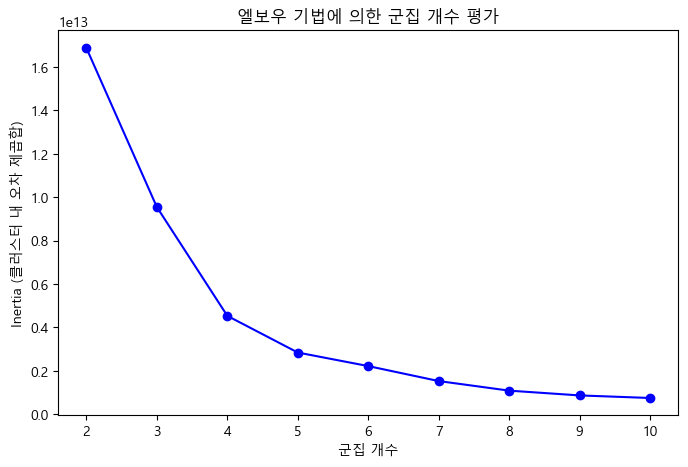

실루엣 점수 계산 진행: 100%|██████████| 3/3 [18:41<00:00, 373.91s/it]


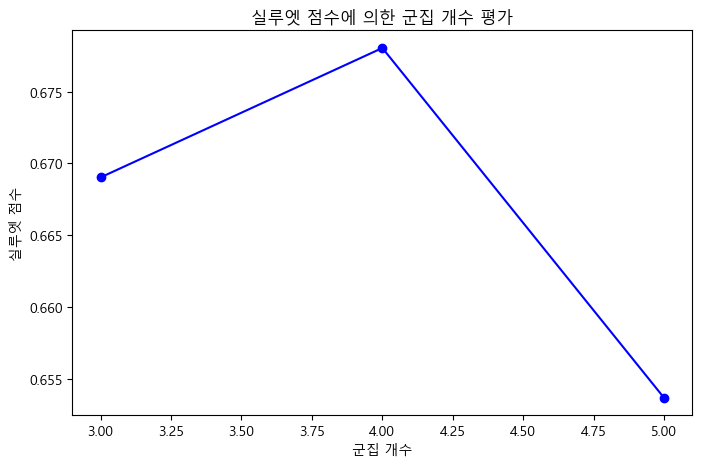

최적 군집 개수: 4, 실루엣 점수: 0.6780453650460021


In [519]:
optimal_k, best_score = find_optimal_clusters(X_scaled, batch_size=100)

In [616]:
kmeans = KMeans(n_clusters=4, random_state=42)
foot_traffic_loc_with_area['CLUSTERING'] = kmeans.fit_predict(X_scaled)

## 2-3. 클러스터링 분석

In [617]:
foot_traffic_loc_with_area.head(3)

,AREA_NM,장소혼잡도지표,실시간인구지표최소값,실시간인구지표최대값,상주인구비율,비상주인구비율,실시간인구데이터업데이트시간,WiFi_Count,요일,시간대,geometry,AREA_M2,와이파이_밀집도,coverage_area,장소혼잡도지표_숫자,요일_숫자,요일_사인,CLUSTERING
0,4·19 카페거리,여유,1000,1500,31.6,68.4,2024-11-13 10:55:00,2,수요일,10,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,0.075579,12580.571067,0,2,0.974928,2
1,4·19 카페거리,여유,1000,1500,30.9,69.1,2024-11-13 11:00:00,2,수요일,11,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,0.075579,12580.571067,0,2,0.974928,2
2,4·19 카페거리,여유,1000,1500,30.6,69.4,2024-11-13 11:10:00,2,수요일,11,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,0.075579,12580.571067,0,2,0.974928,2


### 2-3-1. 지도

In [618]:
foot_traffic_loc_with_area['CLUSTERING'].value_counts()

CLUSTERING
2    111929
0     49852
1     10408
3       461
Name: count, dtype: int64

In [619]:
max_traffic_by_hour_and_location = (
    foot_traffic_loc_with_area.groupby(['시간대', 'AREA_NM', 'WiFi_Count', 'geometry', 'CLUSTERING'])[['실시간인구지표최대값', '장소혼잡도지표_숫자', '와이파이_밀집도']]
    .mean()
    .reset_index()
)

In [620]:
# 클러스터별 색상 매핑
color_mapping = {
    0: "red",
    1: "blue",
    2: "yellow",
    3: "green"
}

In [621]:
import folium
import folium
from shapely.wkt import loads

import folium
from shapely.wkt import loads

# 지도 초기화 (서울 중심 좌표 사용)
seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 클러스터별 색상 매핑
color_mapping = {
    0: "red",
    1: "blue",
    2: "yellow",
    3: "green"
}

# 와이파이 데이터 추가
wifi_layer = folium.FeatureGroup(name="WiFi Locations", show=True)
for _, wifi_row in wifi_data.iterrows():
    # 와이파이 위치를 40m 반경의 원으로 추가
    folium.Circle(
        location=[wifi_row["위도"], wifi_row["경도"]],
        radius=40,  # 반경 40m
        color="purple",
        fill=True,
        fill_color="purple",
        fill_opacity=0.4,
        tooltip=wifi_row["ap명"],
    ).add_to(wifi_layer)

# 와이파이 레이어 지도에 추가
wifi_layer.add_to(seoul_map)

# 시간대별 Layer 추가
time_slots = sorted(max_traffic_by_hour_and_location["시간대"].unique())
for time_slot in time_slots:
    # 시간대별 데이터 필터링
    time_data = max_traffic_by_hour_and_location[
        max_traffic_by_hour_and_location["시간대"] == time_slot
    ]
    
    # FeatureGroup 생성 (각 시간대별로 Layer 분리)
    feature_group = folium.FeatureGroup(name=f"{time_slot}시", show=(time_slot == 10))  # 기본적으로 10시 활성화

    for _, row in time_data.iterrows():
        # 다각형 좌표 추출
        polygon = row["geometry"]
        if isinstance(polygon, str):  # 문자열인 경우 WKT를 로드하여 Polygon 생성
            polygon = loads(polygon)

        # 다각형 좌표 변환 (shapely geometry -> list of lat/lon pairs)
        polygon_coords = [[point[1], point[0]] for point in polygon.exterior.coords]

        # 팝업 정보 생성
        popup_html = f"""
        <div style="width: 200px;">
            <strong>장소명: {row['AREA_NM']}</strong><br>
            클러스터: {row['CLUSTERING']}<br>
            WiFi 개수: {row['WiFi_Count']}<br>
            WiFi 밀집도: {row['와이파이_밀집도']}<br>
            실시간인구지표최대값: {row['실시간인구지표최대값']}<br>
            장소 혼잡도: {row['장소혼잡도지표_숫자']}
        </div>
        """
        popup = folium.Popup(popup_html, max_width=250)

        # 다각형 추가
        folium.Polygon(
            locations=polygon_coords,  # 다각형 좌표
            color=color_mapping[row["CLUSTERING"]],  # 클러스터별 색상
            fill=True,  # 채우기 여부
            fill_color=color_mapping[row["CLUSTERING"]],  # 채우기 색상
            fill_opacity=0.4,  # 투명도
            popup=popup,  # 팝업 추가
            tooltip=row["AREA_NM"],  # 마우스 오버 시 표시되는 이름
        ).add_to(feature_group)

    # 시간대별 레이어 추가
    feature_group.add_to(seoul_map)

# LayerControl 추가 (시간대별 레이어 및 와이파이 레이어 선택 가능)
folium.LayerControl(collapsed=False).add_to(seoul_map)

# 지도 저장
output_file = "time_based_max_traffic_clusters_with_wifi.html"
seoul_map.save(output_file)
print(f"지도가 '{output_file}'로 저장되었습니다.")

지도가 'time_based_max_traffic_clusters_with_wifi.html'로 저장되었습니다.


클러스터링된 각각의 군집이 어떠한 의미를 가지고 있는지 분석해야함

### 2-3-2. 군집 의미 파악

In [622]:
features = [
    "실시간인구지표최대값",
    "장소혼잡도지표_숫자",
    "비상주인구비율",
    "WiFi_Count",
    "요일_숫자",
    "시간대",
    "와이파이_밀집도"
]

In [623]:
foot_traffic_loc_with_area['CLUSTERING'].value_counts()

CLUSTERING
2    111929
0     49852
1     10408
3       461
Name: count, dtype: int64

C:\Users\jungb\AppData\Local\Temp\ipykernel_75676\360933512.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


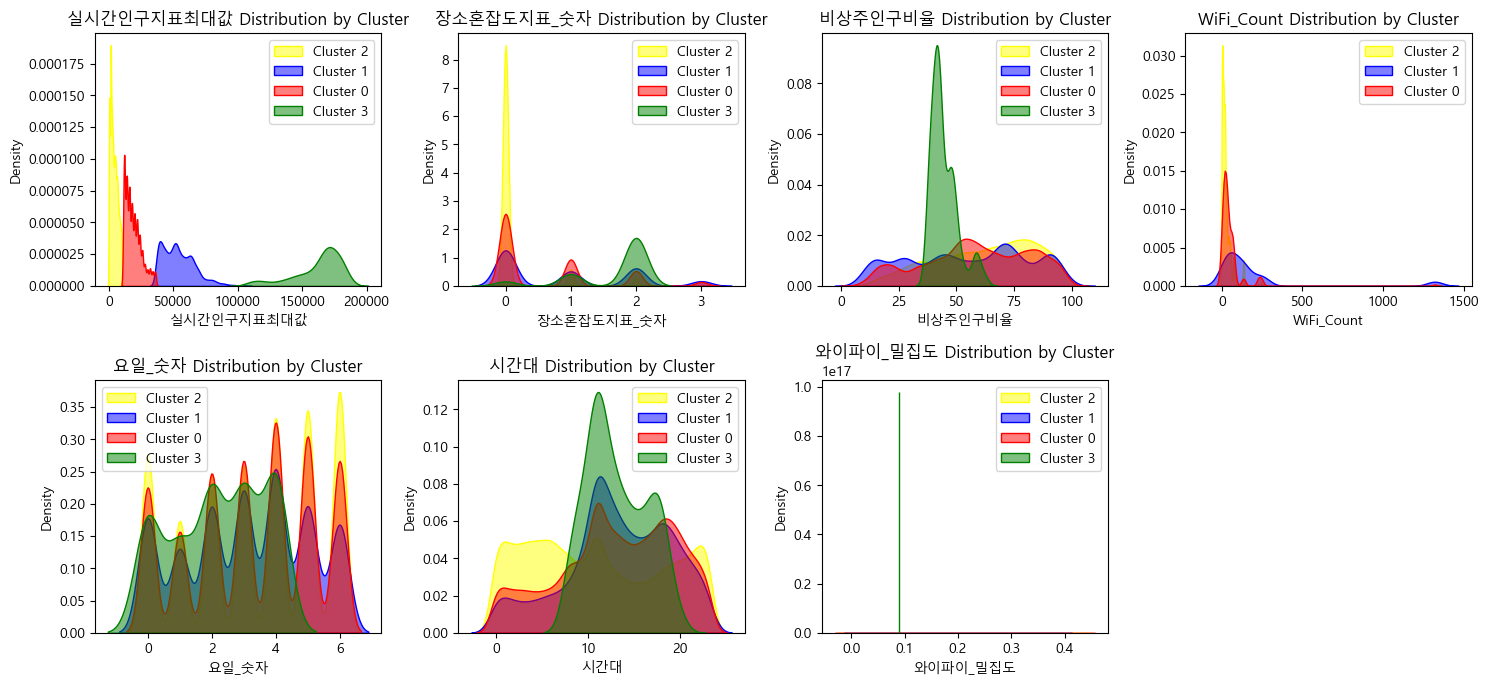

In [624]:
# KDE 플롯 시각화
plt.figure(figsize=(15, 10))
colors = {0: "red", 1: "blue", 2: "yellow", 3: "green"}  # 클러스터별 색상 지정

for i, feature in enumerate(features):
    plt.subplot(3, 4, i + 1)
    for cluster in foot_traffic_loc_with_area["CLUSTERING"].unique():
        sns.kdeplot(
            data=foot_traffic_loc_with_area[foot_traffic_loc_with_area["CLUSTERING"] == cluster],
            x=feature,
            label=f"Cluster {cluster}",
            fill=True,
            alpha=0.5,
            color=colors[cluster]  # 클러스터별 색상 지정
        )
    plt.title(f"{feature} Distribution by Cluster")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

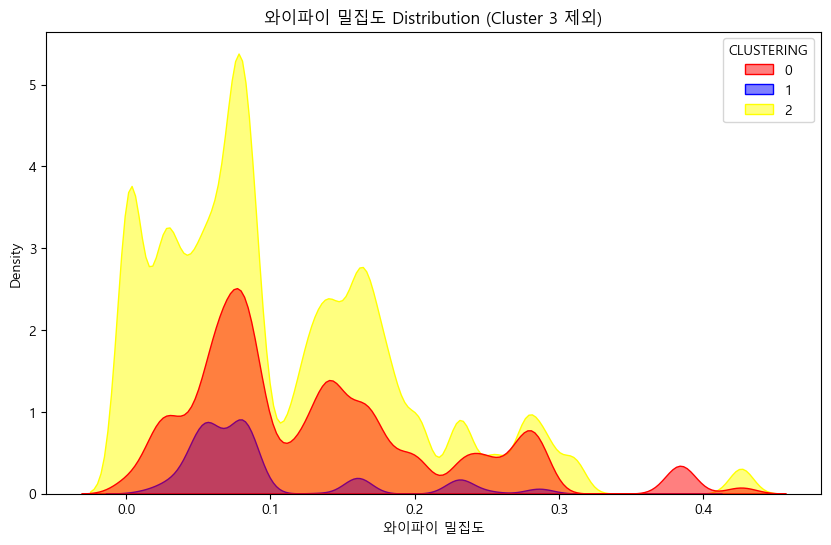

In [625]:
# Cluster 3을 제외한 데이터 필터링
filtered_data = foot_traffic_loc_with_area[foot_traffic_loc_with_area["CLUSTERING"] != 3]

# 와이파이 밀집도 시각화
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=filtered_data,
    x="와이파이_밀집도",
    hue="CLUSTERING",
    fill=True,
    alpha=0.5,
    palette=["red", "blue", "yellow"],  # Cluster 0, 1, 2 색상
)
plt.title("와이파이 밀집도 Distribution (Cluster 3 제외)")
plt.xlabel("와이파이 밀집도")
plt.ylabel("Density")
plt.show()

In [626]:
foot_traffic_loc_with_area[foot_traffic_loc_with_area['CLUSTERING']==3]['AREA_NM'].unique()

array(['여의도'], dtype=object)

# 3. 분석 결론

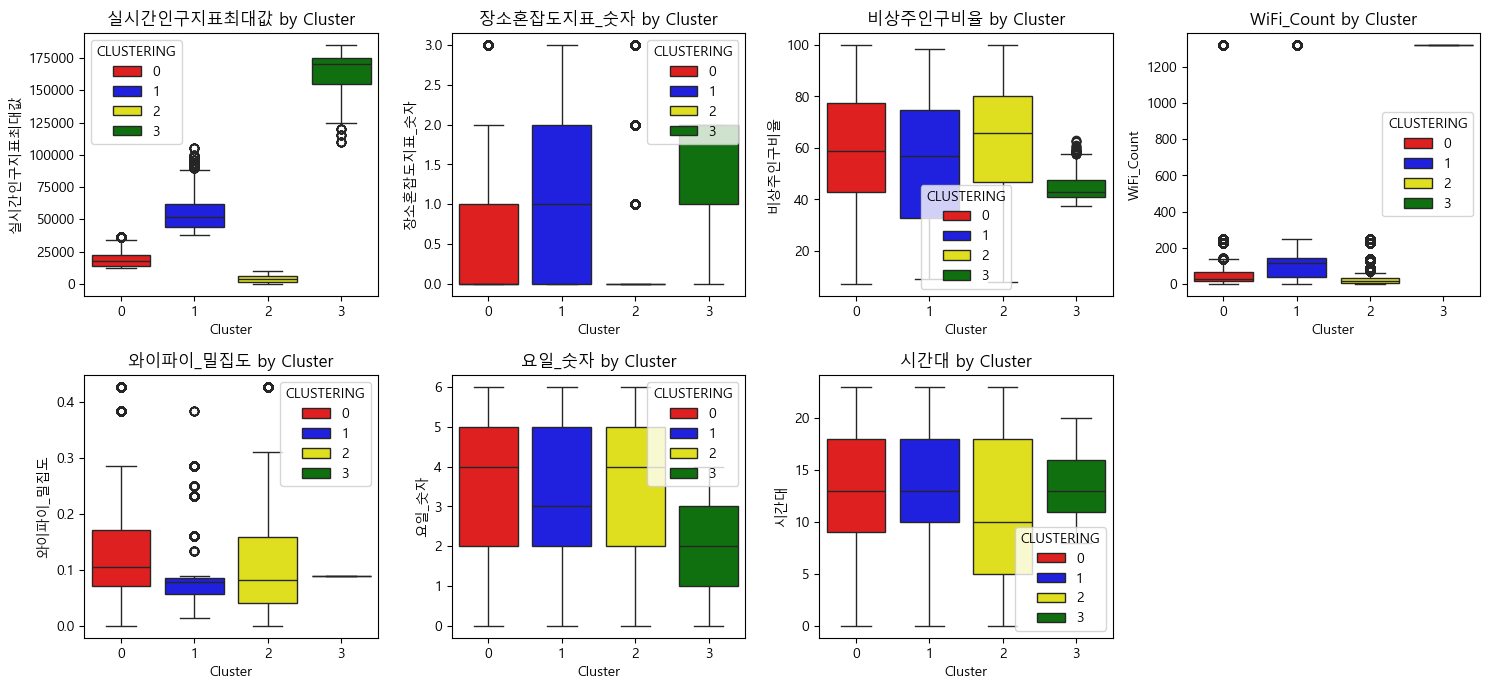

In [627]:
features = [
    "실시간인구지표최대값",
    "장소혼잡도지표_숫자",
    "비상주인구비율",
    "WiFi_Count",
    "와이파이_밀집도",
    "요일_숫자",
    "시간대",
]

cluster_column = "CLUSTERING"

# 1. 군집별 주요 변수 요약
cluster_summary = (
    foot_traffic_loc_with_area.groupby(cluster_column)[features]
    .agg(["mean", "median", "std"])
    .reset_index()
)

# 2. 변수별 군집 간 차이 시각화
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=foot_traffic_loc_with_area, 
                x=cluster_column, 
                y=feature, 
                hue=cluster_column,
                palette=["red", "blue", "yellow", "green"])
    plt.title(f"{feature} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

### 군집별 특성

#### - 군집 0: 균형적인 지역
> - **실시간 인구 지표**: 낮은 수준, 안정적임.
> - **장소 혼잡도**: 중간 수준, 큰 편차 없음.
> - **상주 인구 비율**: 중간 정도로 안정적.
> - **비상주 인구 비율**: 상주 인구와 비슷한 수준, 균형이 잡혀 있음.
> - **WiFi 개수**: 낮은 편.
> - **WiFi 밀집도**: 낮은 수준으로 안정적.
> - **요일 사인**: 주중과 주말이 균형적임.
> - **시간대**: 다양한 시간대에 걸쳐 분포.
> - **특징**:
>> - 유동 인구와 상주·비상주 인구 비율이 균형적으로 분포된 지역.
>> - WiFi와 관련된 지표가 안정적이지만 상대적으로 낮음.

#### - 군집 1: 상주 인구 중심 지역
> - **실시간 인구 지표**: 중간 정도.
> - **장소 혼잡도**: 중간 정도로 안정적.
> - **상주 인구 비율**: 가장 높은 수준.
> - **비상주 인구 비율**: 낮음.
> - **WiFi 개수**: 낮음.
> - **WiFi 밀집도**: 낮음.
> - **요일 사인**: 주중에 집중.
> - **시간대**: 주중 낮 시간대 활동성이 높음.
> - **특징**:
>> - 상주 인구가 대부분을 차지하는 지역.
>> - 비상주 인구가 적고 WiFi와 관련된 지표는 낮음.

#### - 군집 2: 비상주 인구 중심 지역
> - **실시간 인구 지표**: 낮음.
> - **장소 혼잡도**: 낮음.
> - **상주 인구 비율**: 중간 수준.
> - **비상주 인구 비율**: 가장 높음.
> - **WiFi 개수**: 높음.
> - **WiFi 밀집도**: 높음.
> - **요일 사인**: 주말에 집중.
> - **시간대**: 특정 시간대에 집중되지 않고 분산.
> - **특징**:
>> - 비상주 인구가 주를 이루는 지역.
>> - WiFi 관련 지표가 높아, 외부 방문객의 활동이 많은 지역으로 보임.

#### - 군집 3: 특수 지역 (여의도 중심)
> - **실시간 인구 지표**: 가장 높음.
> - **장소 혼잡도**: 높음.
> - **상주 인구 비율**: 높음.
> - **비상주 인구 비율**: 매우 낮음.
> - **WiFi 개수**: 매우 높음.
> - **WiFi 밀집도**: 가장 높음.
> - **요일 사인**: 주중 활동성 높음.
> - **시간대**: 출퇴근 시간대와 주중 낮 시간에 집중.
> - **특징**:
>> - 여의도라는 특수 지역으로, 업무와 행정 중심지의 특징을 보임.
>> - WiFi와 관련된 지표가 매우 높고, 비상주 인구가 거의 없음.

---

### 결론

#### **와이파이 설치 우선순위**
1. **군집 2 (비상주 인구 중심 지역)**:
   - 외부 방문객이 많아 공공 WiFi의 필요성이 높음.
   - 추가 설치가 방문객 편의 증대에 직접적으로 기여.

2. **군집 0 (균형 지역)**:
   - 유동 인구와 인구 비율이 고르게 분포되어 있음.
   - 공공 WiFi 추가 설치로 지역적 균형 효과를 기대할 수 있음.

3. **군집 1 (상주 인구 중심 지역)**:
   - 상주 인구가 주로 사용하는 지역으로, 공공 WiFi 사용량이 상대적으로 적을 가능성.

4. **군집 3 (여의도)**:
   - 업무 중심 지역으로, 사내 WiFi 의존도가 높아 공공 WiFi 설치 우선순위가 낮음.

#### **설치 필요성 판단**
- **군집 2**: 방문객이 많은 장소에서 공공 WiFi 사용량이 높을 가능성이 큼. **설치 우선 지역**.
- **군집 0**: 공공 WiFi로 지역적 균형과 편의성을 증대할 가능성.
- **군집 1**: WiFi의 사용 목적이 상주민에 한정될 가능성이 있어 필요성이 낮음.
- **군집 3**: 사내 WiFi 사용이 주를 이룰 가능성이 크므로 추가 설치 필요성은 제한적.

이 분석은 군집별 특성과 공공 WiFi 설치 우선순위를 체계적으로 제안하며, 특정 지역의 공공 서비스 개선 전략 수립에 활용될 수 있음.

# 4. 세부 분석

In [628]:
# 시간대별 군집 데이터를 지역별로 집계하여 대표 군집 선정
representative_clusters = (
    foot_traffic_loc_with_area.groupby("AREA_NM")["CLUSTERING"]
    .agg(lambda x: x.value_counts().idxmax())  # 가장 많이 나타난 군집을 대표 군집으로 선정
    .reset_index(name="CLUSTERING_representative")
)

# foot_traffic_loc_with_area에 대표 군집 컬럼 추가
foot_traffic_loc_with_area = foot_traffic_loc_with_area.merge(
    representative_clusters, on="AREA_NM", how="left"
)

In [636]:
# 군집 2에 속한 지역 필터링
cluster_2_data = foot_traffic_loc_with_area[
    foot_traffic_loc_with_area["CLUSTERING_representative"] == 2
]

In [650]:
# 와이파이 부족분 계산
cluster_2_data["wifi_deficit"] = (
    (cluster_2_data["실시간인구지표최대값"] / 50)  # 와이파이 1대당 50명 기준
    - cluster_2_data["WiFi_Count"]
).clip(lower=0)  # 부족분은 음수가 될 수 없으므로 0으로 클리핑


# 설치 우선순위 점수 계산 (가중치 조합)
cluster_2_data["priority_score"] = (
    cluster_2_data["wifi_deficit"] * 0.5
    + cluster_2_data["장소혼잡도지표_숫자"] * 0.3
    + cluster_2_data["와이파이_밀집도"] * 0.2
)

# 점수를 기준으로 상위 3개 지역 선정
top_3_priority_areas = (
    cluster_2_data.groupby("AREA_NM")
    .agg(
        실시간인구지표최대값=("실시간인구지표최대값", "max"),
        WiFi_Count=("WiFi_Count", "max"),
        wifi_deficit=("wifi_deficit", "max"),
        와이파이_밀집도=("와이파이_밀집도", "mean"),
        priority_score=("priority_score", "mean"),
    )
    .sort_values("priority_score", ascending=False)
    .head(3)
)

C:\Users\jungb\AppData\Local\Temp\ipykernel_75676\2182998403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2_data["wifi_deficit"] = (
C:\Users\jungb\AppData\Local\Temp\ipykernel_75676\2182998403.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2_data["priority_score"] = (


In [651]:
print("설치가 시급한 군집 2 지역 상위 3곳:")
print(top_3_priority_areas)

설치가 시급한 군집 2 지역 상위 3곳:
          실시간인구지표최대값  WiFi_Count  wifi_deficit  와이파이_밀집도  priority_score
AREA_NM                                                                 
역삼역            42000           2         838.0  0.014670      168.046177
광화문·덕수궁        48000          35         925.0  0.086135      163.390492
구로디지털단지역       40000          11         789.0  0.043971      145.875720


In [647]:
top_3_priority_areas

,실시간인구지표최대값,WiFi_Count,wifi_deficit,와이파이_밀집도,priority_score
AREA_NM,,,,,
노들섬,2500,1,inf,0.0,inf
국립중앙박물관·용산가족공원,3500,1,inf,0.0,inf
청와대,1500,1,inf,0.0,inf
